In [1]:
# Imports
import os

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms import Compose, Resize, ToTensor
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import pandas as pd
import numpy as np
import spacy
from collections import Counter
import matplotlib.pyplot as plt

import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

from PIL import Image
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Vocabulary Class

In [3]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}
    
    def __len__(self):
        return len(self.itos)
    
    # @staticmethod
    # def tokenizer_eng(text):
    #     return [tok.text.lower() for tok in spacy.load("en_core_web_sm").tokenizer(text)]
    
    @staticmethod
    def tokenizer_eng(text):
        return text.lower().strip().split()
    
    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                frequencies[word] += 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)
        return [
            self.stoi.get(token, self.stoi["<UNK>"])
            for token in tokenized_text
        ]

We will be using the Flickr8k dataset.

In [4]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=2):
        self.df = pd.read_csv(captions_file)
        self.root_dir = root_dir
        self.transform = transform

        self.imgs = self.df["image"].tolist()
        raw_captions = self.df["caption"].tolist()
        
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(raw_captions)

        # Preprocess all captions once
        self.captions = []
        for cap in raw_captions:
            tokens = [self.vocab.stoi["<SOS>"]]
            tokens += self.vocab.numericalize(cap)
            tokens.append(self.vocab.stoi["<EOS>"])
            self.captions.append(torch.tensor(tokens))

    def __len__(self):
        return len(self.captions)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        caption = self.captions[idx]
        return img, caption

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def collate_fn(batch):
    images = []
    captions = []
    for img, cap in batch:
        images.append(img)
        captions.append(cap)
    
    images = torch.stack(images)
    captions = nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=0)
    return images, captions

Modelle: ResNet50 for Image Feature Extraction and LSTM for language processing

In [6]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT) 
        for param in resnet.parameters():
            param.requires_grad = False
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)
    
    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        return self.fc(features)


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.init_h = nn.Linear(embed_size, hidden_size)
        self.init_c = nn.Linear(embed_size, hidden_size)

    def forward(self, features, captions):
        embeddings = self.embed(captions[:, :-1])  # input tokens
        h0 = self.init_h(features).unsqueeze(0)  # (1, batch, hidden_size)
        c0 = self.init_c(features).unsqueeze(0)

        hiddens, _ = self.lstm(embeddings, (h0, c0))
        outputs = self.fc(hiddens)
        return outputs

Helper functions

In [7]:
def train(model, dataloader, criterion, optimizer, vocab_size, num_epochs=5):
    for epoch in range(num_epochs):
        print(f"Start epoch {epoch}")
        for idx, (imgs, captions) in enumerate(dataloader):
            imgs, captions = imgs.to(device), captions.to(device)

            features = encoder(imgs)
            outputs = decoder(features, captions)

            loss = criterion(outputs.view(-1, vocab_size), captions[:, 1:].reshape(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

In [8]:
def caption_image(encoder, decoder, image, vocab, max_length=50):
    result_caption = []

    with torch.no_grad():
        x = encoder(image.unsqueeze(0).to(device))
        states = None
        word = torch.tensor([vocab.stoi["<SOS>"]]).to(device)

        for _ in range(max_length):
            embedding = decoder.embed(word).unsqueeze(1)
            hiddens, states = decoder.lstm(embedding, states)
            output = decoder.fc(hiddens.squeeze(1))
            predicted = output.argmax(1)

            word = predicted
            predicted_word = vocab.itos[predicted.item()]
            if predicted_word == "<EOS>":
                break
            result_caption.append(predicted_word)

    return " ".join(result_caption)

Download Flickr8k dataset:
https://www.kaggle.com/datasets/adityajn105/flickr8k

Convert txt file to csv file. Goal is to use csv directly in the dataloader

In [9]:
# txt_path = "Flickr8k_text/captions.txt"
# csv_path = "Flickr8k_text/captions.csv"

In [10]:
# df = pd.read_csv(txt_path)
# df.to_csv(csv_path, index=False)

In [11]:
# def filter_existing_images(csv_path, image_dir, output_path):
#     df = pd.read_csv(csv_path)
#     df = df[df["image"].apply(lambda x: os.path.exists(os.path.join(image_dir, x)))]
#     df.to_csv(output_path, index=False)
#     print(f"Saved filtered CSV to {output_path} with {len(df)} entries.")

# filter_existing_images(
#     csv_path="Flickr8k_text/captions.csv",
#     image_dir="Flickr8k_dataset",
#     output_path="Flickr8k_text/captions_filtered.csv"
# )

In [12]:
# Load dataset
dataset = FlickrDataset(
    root_dir="Flickr8k_dataset",
    captions_file="Flickr8k_text/captions_filtered.csv",
    transform=transform
)

In [13]:
# Create dataloaders
loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn, num_workers=4)

In [14]:
# Hyperparameter
embed_size = 256
hidden_size = 512
vocab_size = len(dataset.vocab)
num_epochs = 10
learning_rate = 3e-4

# Models
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size).to(device)

# Optimizer & Loss
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
params = list(decoder.parameters()) + list(encoder.fc.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

# Training
train((encoder, decoder), loader, criterion, optimizer, vocab_size, num_epochs)

Start epoch 0
Epoch [1/10], Loss: 3.4212
Start epoch 1
Epoch [2/10], Loss: 3.3717
Start epoch 2
Epoch [3/10], Loss: 3.1493
Start epoch 3
Epoch [4/10], Loss: 2.6388
Start epoch 4
Epoch [5/10], Loss: 2.4542
Start epoch 5
Epoch [6/10], Loss: 2.4140
Start epoch 6
Epoch [7/10], Loss: 2.2948
Start epoch 7
Epoch [8/10], Loss: 2.2958
Start epoch 8
Epoch [9/10], Loss: 2.1460
Start epoch 9
Epoch [10/10], Loss: 2.2175


Caption Generation

In [15]:
def show_caption(image_path, encoder, decoder, vocab, transform):
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).to(device)

    caption = caption_image(encoder, decoder, img_tensor, vocab)
    
    plt.imshow(image)
    plt.title(caption)
    plt.axis("off")
    plt.show()

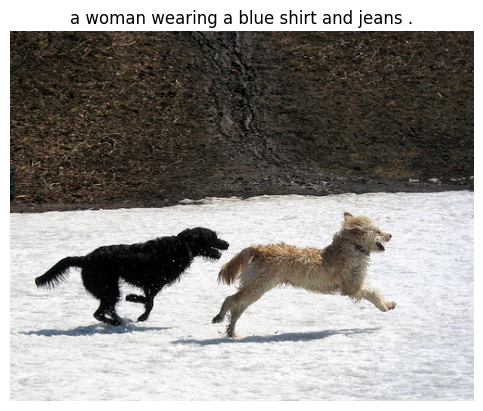

In [16]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Use picture from Flickr8k_Dataset
image_path = "Flickr8k_dataset/2513260012_03d33305cf.jpg"
show_caption(image_path, encoder, decoder, dataset.vocab, transform)